In [1]:
import pandas as pd 
import numpy as np

# for timestamps
from datetime import datetime
from datetime import timedelta

# imports to find autocorrelation plots
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# imports for partial correlation plots
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

#decomposing time series
from statsmodels.tsa.seasonal import seasonal_decompose

# for plotting
import matplotlib.pyplot as plt

#for adfuller test
from statsmodels.tsa.stattools import adfuller

# for performance metrics
from sklearn.metrics import mean_squared_error

## Modelling using ARIMA/SARIMA

Our goals/ requirements to use a SARIMA model are as follows

- Our data must be continuous with out any breaks and must have a constant frequency (daily,weekly,monthly)
- Our data is stationary, this means No trends and no seasonality
- Our data is homscedastic which means that it's of the same variance throughout 
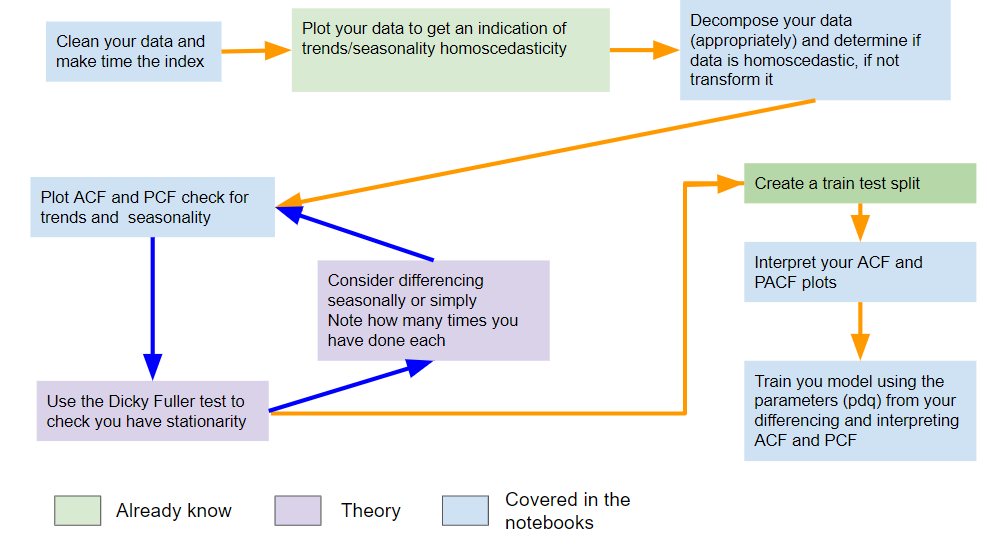


In [2]:
# let's get some data

path = './data/airline.csv'
airline = pd.read_csv(path, header = 0, names = ['Month', 'passengers'])

## 1. Cleaning

In [3]:
airline.tail()
airline.drop(144,axis = 0, inplace = True)
#airline.columns

In [4]:
airline.tail()

,Month,passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [5]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


## 2. Set time as the index

In [6]:
#changing to datetime format
airline['Month'] = pd.to_datetime(airline['Month'])
#setting index
airline.set_index('Month', inplace=True)

In [7]:
# make sure there are no gaps in the index
airline = airline.resample("M").pad()

# sort 
airline = airline.sort_index()
#airline = airline.asfreq('M')


airline.head()
airline.index

DatetimeIndex(['1949-01-31', '1949-02-28', '1949-03-31', '1949-04-30',
               '1949-05-31', '1949-06-30', '1949-07-31', '1949-08-31',
               '1949-09-30', '1949-10-31',
               ...
               '1960-03-31', '1960-04-30', '1960-05-31', '1960-06-30',
               '1960-07-31', '1960-08-31', '1960-09-30', '1960-10-31',
               '1960-11-30', '1960-12-31'],
              dtype='datetime64[ns]', name='Month', length=144, freq='M')

In [8]:
airline.isnull().sum()

passengers    0
dtype: int64

In [9]:
airline.fillna(method='pad', inplace=True)

In [10]:
airline.isnull().sum()

passengers    0
dtype: int64

## 3. Plot to detect seasonality and trends

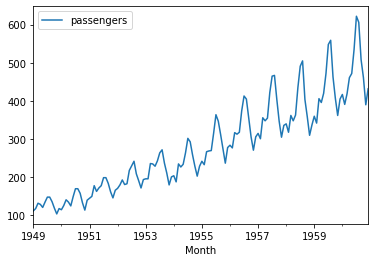

In [11]:
airline.plot();

In [12]:
# clear upward trend, clear seasonality we will have to quite a bit of work to get this data to a stationary time series

## 4. Decompose


REMEMBER if you don't have seasonality decompose by finding the MA and subtracting it from the data, OR by fitting a polynomial line and subtracting it this will gove you the residual.

<Figure size 432x288 with 0 Axes>

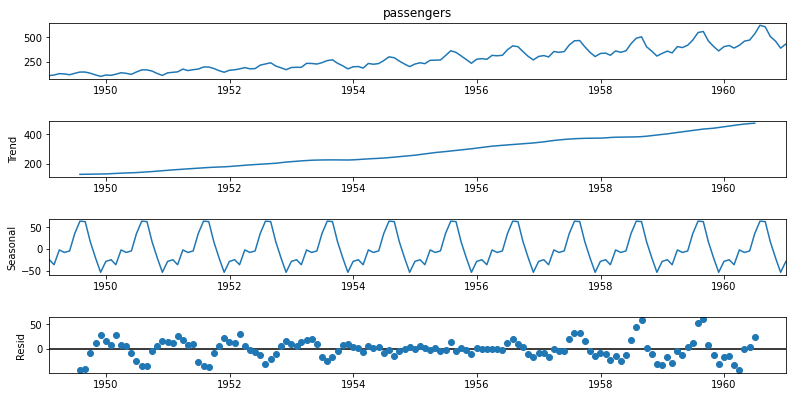

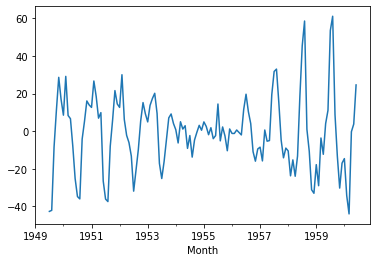

In [13]:
decomposition = seasonal_decompose(airline['passengers'], period = 12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)

plt.show();


decomposition.resid.plot();

In [14]:
# there is an upward trend, seasonal effects and our residuals show that we have hetroscedacity ( changing variance)
# we have a lot to fix

In [15]:
airline['logged'] = np.log(airline['passengers'])
airline.head()

,passengers,logged
Month,,
1949-01-31,112.0,4.718499
1949-02-28,118.0,4.770685
1949-03-31,132.0,4.882802
1949-04-30,129.0,4.859812
1949-05-31,121.0,4.795791


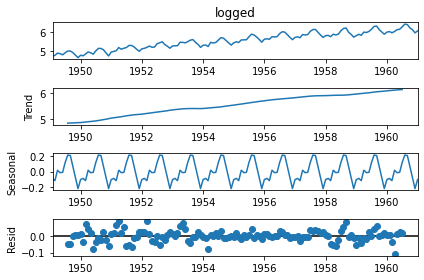

In [16]:
# to help with the hetroscedacity we can use a transformation because the graph is gowing by a factor of 1.5 per year(roughly)
# taking the log of the passenger number will smooth out this change. (hopefully fixing the hetroscedaciousness)
log_decomposition = seasonal_decompose(airline['logged'], period = 12)  
#our hetroscedacity has improved so we can move on to trying to make our data stationary

fig=log_decomposition.plot();


## 5.Acheive stationarity

In [17]:
# we need a stationary time series no trends no seasonality
# use dickeyfuller test to check this
stationary_test = adfuller(airline['passengers'])
# It is not stationary as the p-value is > 0.05
# we will need to do some work to get this to be forecastable
stationary_test[1]




0.9918802434376411

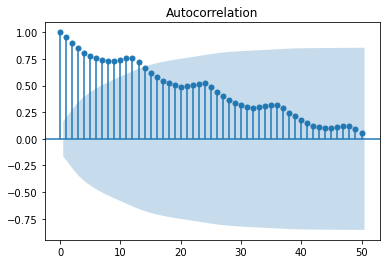

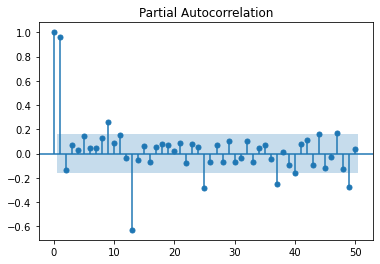

In [18]:
# transforming wasn't enough we will need to difference to remove the stationarity
plot_acf(airline['logged'].dropna(),lags=50);
plot_pacf(airline['logged'],lags = 50);

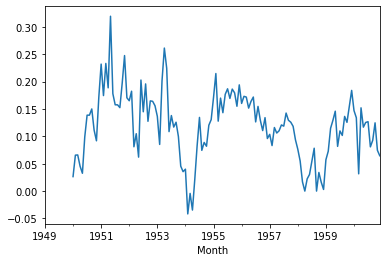

In [19]:
#ACF shows periodic behaviour (seasonality every 12 points), we need to seasonaly difference this to try to eliminate it
seasonally_differenced = airline['logged'].diff(12) # 12 for seasonal period

# it now looks much flatter
seasonally_differenced.plot();

In [20]:
# we need a stationary time series no trend no seasonality
# use dickeyfuller test to check this
stationary_test = adfuller(seasonally_differenced.dropna())

stationary_test[1]

0.07239567181769445

In [21]:
# It  is not stationary as the p-value is > 0.05
# we will need to continue improving it to be stationary

In [22]:
# differencing again should bring it in line
# this time difference normally
stationary = seasonally_differenced.diff(1)

stationary_test = adfuller(stationary.dropna())
# looks like we have a stationary timeseries as the p-value is < 0.05

stationary_test[1]




# Note we have seasonally differenced once and differenced once NEVER difference more than twice

0.0002485912311384173

<Figure size 432x288 with 0 Axes>

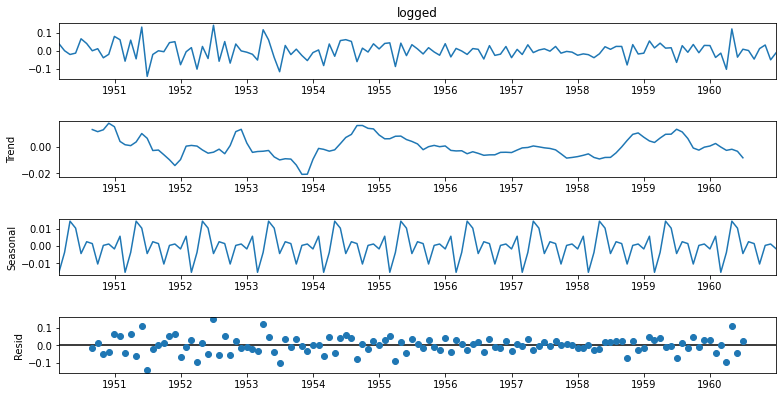

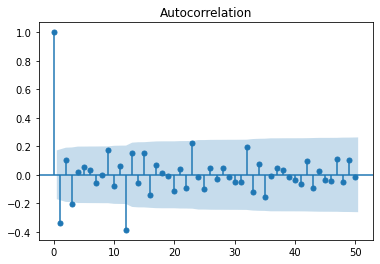

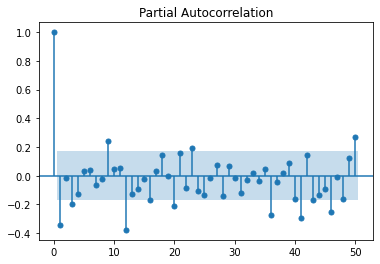

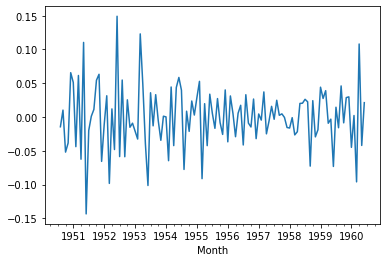

In [23]:
stat_decomposition = seasonal_decompose(stationary.dropna()); 
fig = plt.figure();
fig = stat_decomposition.plot(); 
fig.set_size_inches(12, 6);


plot_acf(stationary.dropna(),lags=50);
plot_pacf(stationary.dropna(),lags = 50);

plt.show();

stat_decomposition.resid.plot();

In [24]:
# having differenced notice that the seasonal and trend contributions are now miniscule!

# This is as stationary as we can get we have extracted as much signal as we can

## 6.Create train test split

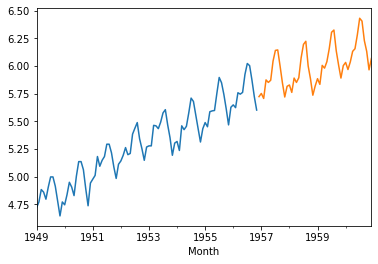

In [25]:
# We need to split up our line in two parts a training part and a test part to see our model's performance
# this is required for us to be able ot comment on the models performance
train_size = 95

# notice we use the transformed data(logged data) to input in to our model 
# we will have to account for this later by reversing it.
train = airline['logged'][:train_size]
test = airline['logged'].iloc[train_size:]
# note depending on which way your dates are 
# sorted this may need changing

# visualise the train-test split to check it seems reasonable
fig, ax = plt.subplots(1, 1)
train.plot(ax=ax);
test.plot(ax=ax);
plt.show();

# IF you transform you timeseries you must use the transformed version to train the model
# blue is training data orange is testing data

## 7. Interpret ACF and PACF to find pdq and s(pdqs) terms


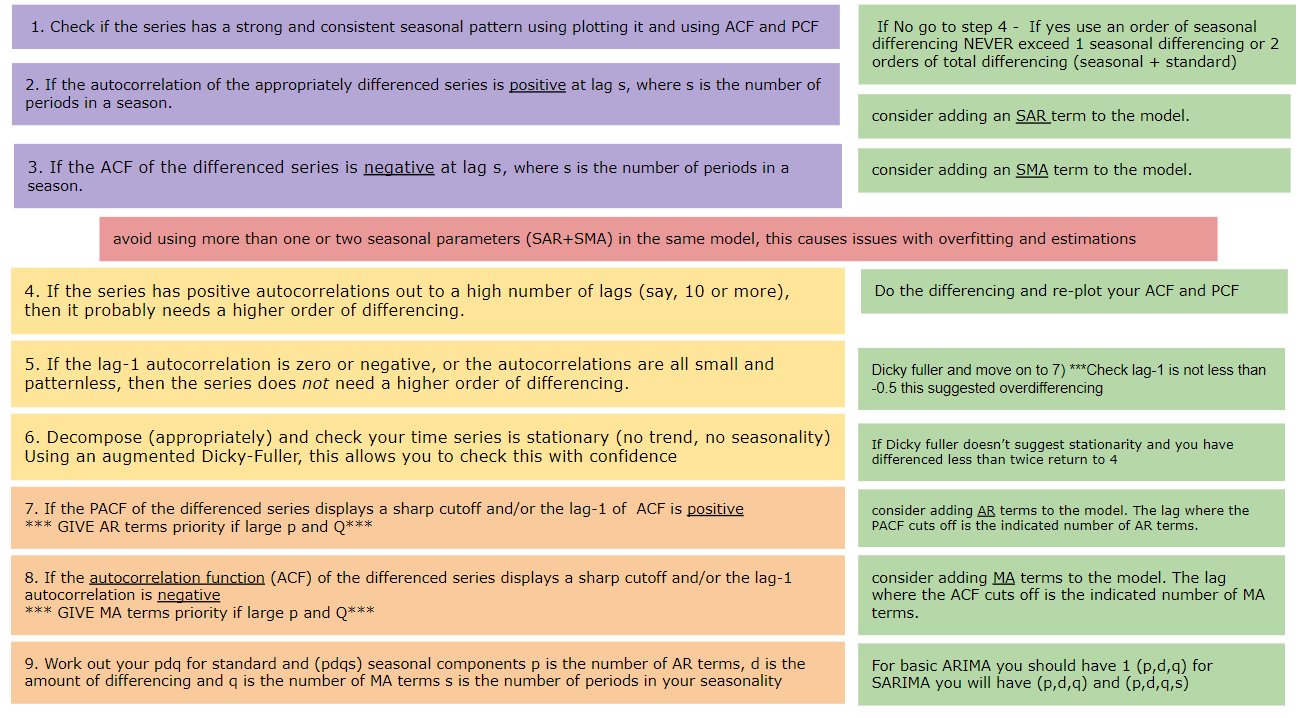


- The time series had to be differenced once seasonally(with period of 12) and once normally so (p,1,q) and (p,1,q,12)
- ACF immediately goes below zero (suggesting differencing was a bit harsh!) goes negative which suggests adding MA terms might be helpful make these the priority if our model parameters are ambiguous.
- ACF has 1st spike below zero so so does PACF so our non-seasonal part will be (0,1,1) 
- 1 ACF spike below zero at 12 so no SAR terms only SMA and 1 is apppropriate(0,1,1,12)



## 8. Build model

In [38]:
# building the model is easy we just input our pdq and pdqs in to the SARIMAX model.
# Note to turn the SARIMAX into an ARIMA for non-seasonal data use fit1 = SARIMAX(train, order=(0,1,1)).fit()
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

test_size = len(airline.index) - train_size



fit1 = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,12)).fit()
# you can refit the model by changing parameters, or even create numerous models with different names
#fit1 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()


forecast1 = fit1.get_forecast(test_size).summary_frame(alpha=0.1)


forecast1.head()

logged,mean,mean_se,mean_ci_lower,mean_ci_upper
1956-12-31,5.740017,0.039132,5.675651,5.804384
1957-01-31,5.767002,0.045701,5.691830,5.842173
1957-02-28,5.743732,0.051436,5.659127,5.828337
1957-03-31,5.893024,0.056593,5.799936,5.986111
1957-04-30,5.876128,0.061318,5.775268,5.976988


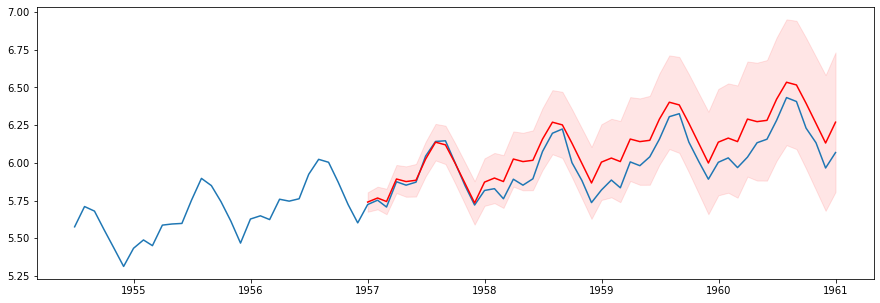

In [27]:
# for the model
fig, ax = plt.subplots(figsize=(15, 5))

# plot the original data
ax.plot(airline.index[train_size-30:], airline['logged'][train_size-30:])

# plot the forecasts
ax.plot(airline.index[-test_size:], forecast1['mean'], color = 'r')

# plot the confidence intervals on the forecasts
ax.fill_between(airline.index[-test_size:], forecast1['mean_ci_lower'], forecast1['mean_ci_upper'], color='r', alpha=0.1);


In [28]:
# now to reverse the transform and see our true prediction

forecast1['restored'] = np.exp(forecast1['mean'])


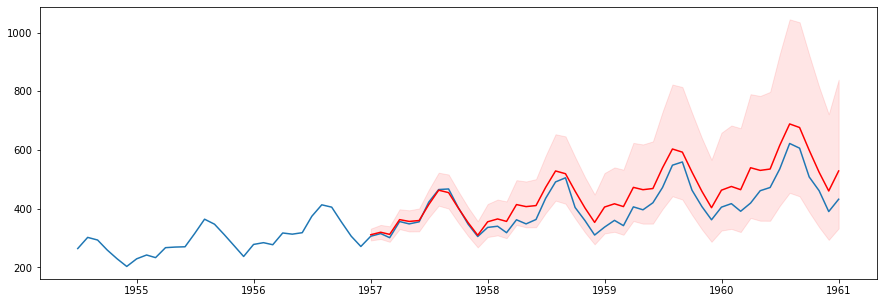

In [29]:
# for the twice_differenced model
fig, ax = plt.subplots(figsize=(15, 5))

# plot the original data training data has been trimmed to allopw a clearer view 
ax.plot(airline.index[train_size-30:], airline['passengers'][train_size-30:])

# plot the forecasts
ax.plot(airline.index[-test_size:], forecast1['restored'], color = 'r')

ax.fill_between(airline.index[-test_size:], np.exp(forecast1['mean_ci_lower']), np.exp(forecast1['mean_ci_upper']), color='r', alpha=0.1);


## 9.Evaluate the performance

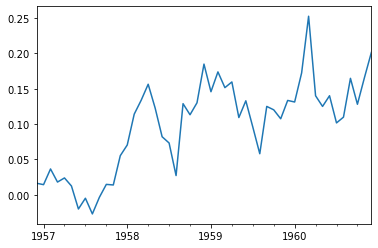

In [30]:
# Take the residuals of your prediction vs the actual values
# if the model has captured all of the signal the residuals will just look like random noise

twice_differenced_resid = forecast1['mean'] - test
twice_differenced_resid.plot();

In [31]:
# residuals have a trend inicating that our model begins to overpredict over time!
# it also indicates that some signal is left for us to extract from the data

In [32]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test, forecast1['mean'])

0.013825329459799612

In [48]:
fit1 = SARIMAX(airline['logged'], order=(0,1,1), seasonal_order=(0,1,1,12)).fit()
forecast1 = fit1.get_forecast(20).summary_frame(alpha=0.1)

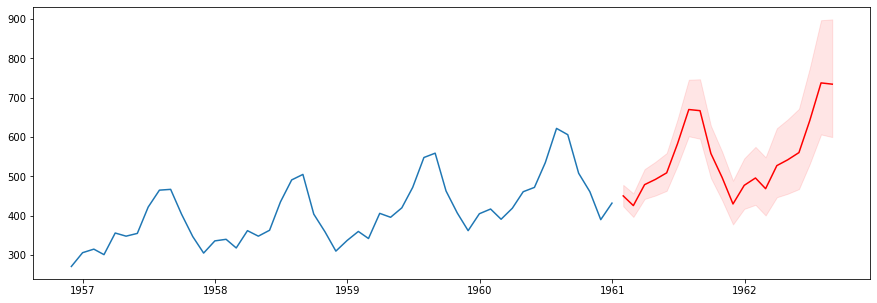

In [51]:
# for the twice_differenced model
fig, ax = plt.subplots(figsize=(15, 5))

# plot the original data training data has been trimmed to allopw a clearer view 
ax.plot(airline.index[-50:], airline['passengers'][-50:])

# plot the forecasts
ax.plot(forecast1.index[:], np.exp(forecast1['mean']), color = 'r')

ax.fill_between(forecast1.index[:], np.exp(forecast1['mean_ci_lower']), np.exp(forecast1['mean_ci_upper']), color='r', alpha=0.1);
